In [ ]:
library(Rpdb)
library(seqinr)
library(UniProt.ws)
library(RCurl)
library(gplots)
library(ggplot2)
library(reshape2)
library(ggrepel)
library(ggpubr)

glyco_impact_aa = c('V','I','L','M','F','Y','W','Q','R','E','K')

# https://www.uniprot.org/uniprot/P04156 (human PrP)
# https://www.uniprot.org/uniprot/P04925 (mouse PrP)

# aa54-aa226 (mouse), offset is 1

# low expression (indication of differential glycosylation)
expression = data.frame(
    res_mouse = c(139,141,161,163,175,214,167,183,218),
    res_human = c(139,141,161,163,175,214,167,183,218)+1,
    expression = 'low',stringsAsFactors=F)

# glycosylation site
glycosite_mouse = c('180','196')
glycosite_human = c('181','197')
aa = unlist(strsplit('ACDEFGHIKLMNPQRSTVWY',''))

# disease mutations
subst = data.frame(
    res_human = c(178,180,196,200,203,208,210,211,232,178,102,105,131,187,198,202,212,217),
    ref = c('D','V','E','E','V','R','V','E','M','D','P','P','G','H','F','D','Q','Q'),
    mut = c('N','I','K','K','I','H','I','Q','R','N','L','L','V','R','S','N','P','R'),
    pheno=c(rep('CJD',9),'FFI',rep('GSD',8)),stringsAsFactors=F
)
subst$res_mouse = subst$res_human-1

# pdb
pdb_human = c('1E1G','1E1J','1E1P','1E1S','1E1U','1E1W') # 125-228
pdb_mouse = c('1AG2','1XYX','1Y15','1Y16','2K5O','2KFM') # 123-225 & 120-231


# load ms mutants
ms_muts = read.csv('validation_data//prion/prp_ms_muts.csv',header=F)

In [3]:
read.pdb_web = function(pdb_id){
    fileConn<-file("tmp.pdb")
    writeLines(getURL(paste0('https://files.rcsb.org/download/',pdb_id,'.pdb')), fileConn)
    close(fileConn)
    read.pdb('tmp.pdb')
}

firstup <- function(x) {
  substr(x, 1, 1) <- toupper(substr(x, 1, 1))
  x
}

eucl_dist3d<-function(x,i,j){
    if(!all(c(i,j)%in%x$atoms$resid)){return(NA)}
    alpha_c = x$atoms$elename =='CA'
    idx_i = x$atoms$resid==i & alpha_c
    idx_j = x$atoms$resid==j & alpha_c
    #as.vector(dist(as.data.frame(lapply(distances(x, idx_i, idx_j),as.vector))))
    as.vector(norm(distances(x,idx_i,idx_j),'xyz'))
}
# table(x$atoms$elename)

In [4]:
res_nums = 120:232
pdb_x = read.pdb_web(pdb_mouse[2])
glyco_dist = data.frame(res_human=res_nums,res_mouse=res_nums-1,
    ref = sapply(res_nums,function(i){
        res = pdb_x$atoms$resname[pdb_x$atoms$resid==i]
        ifelse(length(res)==0,NA,a(firstup(tolower(unique(res)))))
    }),
    g1_dist_human=rowMeans(sapply(pdb_human,function(i){
        x = read.pdb_web(i)
        sapply(res_nums,function(res){
            eucl_dist3d(x,181,res)
    })}),na.rm=T),
    g2_dist_human=rowMeans(sapply(pdb_human,function(i){
        x = read.pdb_web(i)
        sapply(res_nums,function(res){
            eucl_dist3d(x,197,res)
    })}),na.rm=T),
    g1_dist_mouse=rowMeans(sapply(pdb_mouse,function(i){
        x = read.pdb_web(i)
        sapply(res_nums,function(res){
            eucl_dist3d(x,180,res)
    })}),na.rm=T),
    g2_dist_mouse=rowMeans(sapply(pdb_mouse,function(i){
        x = read.pdb_web(i)
        sapply(res_nums,function(res){
            eucl_dist3d(x,196,res)
    })}),na.rm=T))

Warning message in read.pdb("tmp.pdb"):
“Multiple 'CRYST1' records have been found. Only the first record has been kept.”Warning message in read.pdb("tmp.pdb"):
“NAs introduced by coercion”Warning message in read.pdb("tmp.pdb"):
“NAs introduced by coercion”Warning message in read.pdb("tmp.pdb"):
“NAs introduced by coercion”Warning message in read.pdb("tmp.pdb"):
“NAs introduced by coercion”Warning message in read.pdb("tmp.pdb"):
“NAs introduced by coercion”Warning message in read.pdb("tmp.pdb"):
“NAs introduced by coercion”Warning message in read.pdb("tmp.pdb"):
“In 'cryst1': 'abc' contains NA values”Warning message in read.pdb("tmp.pdb"):
“In 'cryst1': 'abg' contains NA values”Warning message in read.pdb("tmp.pdb"):
“Multiple 'CRYST1' records have been found. Only the first record has been kept.”Warning message in read.pdb("tmp.pdb"):
“NAs introduced by coercion”Warning message in read.pdb("tmp.pdb"):
“NAs introduced by coercion”Warning message in read.pdb("tmp.pdb"):
“NAs introduced 

In [5]:
dat=merge(merge(glyco_dist,subst,all=T),expression,all=T)
#head(dat)

ms_muts = read.csv('validation_data//prion/prp_ms_muts.csv',header=F)
#head(ms_muts)
colnames(ms_muts)=c('muts','seqs','ref','res_mouse')
ms_muts$availible = TRUE
ms_muts$res_mouse = ms_muts$res_mouse-1
dat = merge(dat,ms_muts[,-c(1:2)],all=T)
dat$availible = ifelse(is.na(dat$availible),FALSE,TRUE)
#head(dat,n=20)

dat$expression = as.character(ifelse(is.na(dat$expression),'unknown',as.character(dat$expression)))
if(!is.na(dat$mut)&dat$expression=='low'){stop('expression and mutation will overwrite')}
dat$mut =ifelse(dat$expression=='low','R',dat$mut)

dat$glyco_impactful = dat$ref %in% glyco_impact_aa | dat$mut %in% glyco_impact_aa

dat$lab_human = with(dat, paste0(ifelse(glyco_impactful,'*',''),ref,res_human,ifelse(is.na(mut),'',as.character(mut))))
dat$keep_human = with(dat,g1_dist_human<10|g2_dist_human<10)

dat$lab_mouse = with(dat, paste0(ifelse(glyco_impactful,'*',''),ref,res_mouse,ifelse(is.na(mut),'',as.character(mut))))
dat$keep_mouse = with(dat,g1_dist_mouse<10|g2_dist_mouse<10)

dat$pheno = factor(as.character(ifelse(is.na(dat$pheno),'unknown',as.character(dat$pheno))),levels=c('unknown','GSD','CJD','FFI'))
write.csv(dat,file='validation_data/prion/glycosite_proximity.csv')

head(dat[sample(1:nrow(dat)),],n=10)

Warning message in if (!is.na(dat$mut) & dat$expression == "low") {:
“the condition has length > 1 and only the first element will be used”

,res_mouse,ref,res_human,g1_dist_human,g2_dist_human,g1_dist_mouse,g2_dist_mouse,mut,pheno,expression,availible,glyco_impactful,lab_human,keep_human,lab_mouse,keep_mouse
,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<chr>,<lgl>,<lgl>,<chr>,<lgl>,<chr>,<lgl>
18,125,G,126,14.958279,25.257848,15.726886,24.310967,NA,unknown,unknown,FALSE,FALSE,G126,FALSE,G125,FALSE
99,204,M,205,13.075046,13.895691,11.407500,16.083219,NA,unknown,unknown,FALSE,TRUE,*M205,FALSE,*M204,FALSE
108,213,C,214,11.045910,23.468093,7.351805,22.896244,NA,unknown,unknown,FALSE,FALSE,C214,FALSE,C213,TRUE
93,198,T,199,15.386082,6.289403,16.260551,9.941478,NA,unknown,unknown,FALSE,FALSE,T199,TRUE,T198,TRUE
97,202,V,203,10.329186,9.963646,10.527151,12.561399,I,CJD,unknown,FALSE,TRUE,*V203I,TRUE,*V202I,FALSE
77,182,T,183,5.597078,15.766643,5.349816,15.353315,NA,unknown,unknown,FALSE,FALSE,T183,TRUE,T182,TRUE
26,133,M,134,18.751567,24.597543,14.883919,22.116588,NA,unknown,unknown,TRUE,TRUE,*M134,FALSE,*M133,FALSE
4,96,N,NA,NA,NA,NA,NA,NA,unknown,unknown,TRUE,FALSE,NNA,NA,N96,NA
102,207,R,208,11.312318,18.156747,8.772266,19.867917,H,CJD,unknown,FALSE,TRUE,*R208H,FALSE,*R207H,TRUE


In [ ]:
my_comparisons <- list( c("unknown", "GSD"), c("unknown", "CJD"), c("GSD", "CJD") )[c(3,1,2)]

dat=droplevels(dat[dat$pheno!='FFI',])
dat$gi_dist_human = apply(cbind(dat$g1_dist_human,dat$g2_dist_human),1,function(x) ifelse(length(x)>0,min(na.omit(x[is.finite(x)])),NA) )
dat$gi_dist_mouse = apply(cbind(dat$g1_dist_mouse,dat$g2_dist_mouse),1,function(x) ifelse(length(x)>0,min(na.omit(x[is.finite(x)])),NA) )

Warning message:
“Removed 22 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 22 rows containing non-finite values (stat_signif).”Warning message:
“Removed 22 rows containing missing values (geom_point).”Warning message:
“Removed 22 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 22 rows containing non-finite values (stat_signif).”Warning message:
“Removed 22 rows containing missing values (geom_point).”Warning message:
“Removed 13 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 13 rows containing non-finite values (stat_signif).”Warning message:
“Removed 13 rows containing missing values (geom_point).”Warning message:
“Removed 13 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 13 rows containing non-finite values (stat_signif).”Warning message:
“Removed 13 rows containing missing values (geom_point).”Saving 6.67 x 6.67 in image


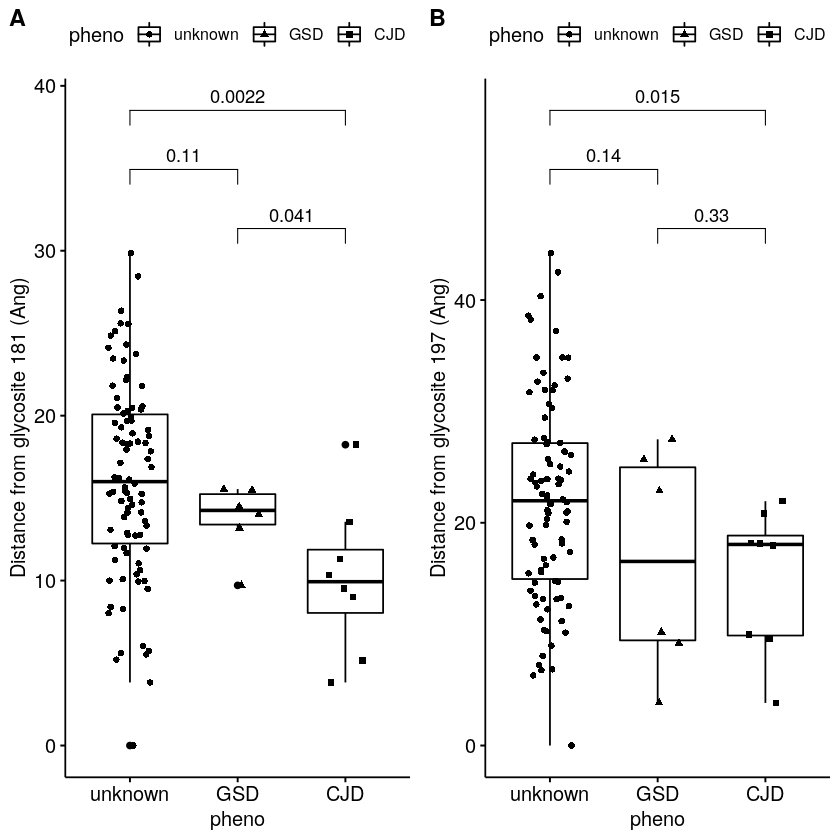

Saving 6.67 x 6.67 in image


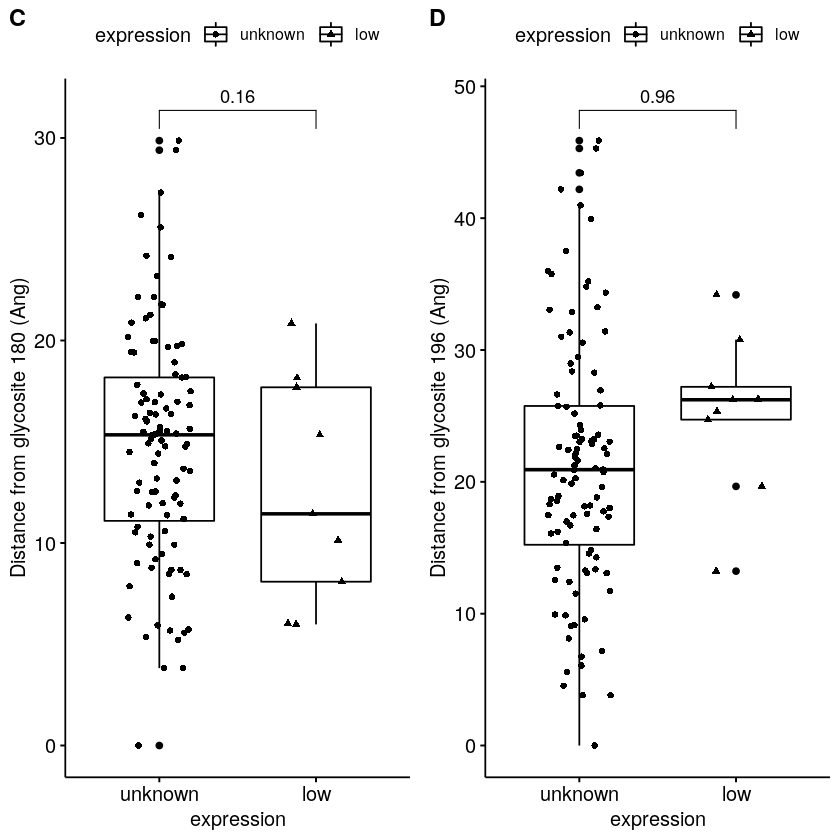

In [43]:

p1 <- ggboxplot(dat, x = "pheno", y = "g1_dist_human",
                #color = "pheno", #palette =c("#00AFBB", "#E7B800", "#FC4E07"),
                add = "jitter", shape = "pheno")+ #stat_compare_means(label.y = 50) 
    ylab('Distance from glycosite 181 (Ang)')+
    stat_compare_means(comparisons = my_comparisons,method.args = list(alternative = "greater"))#+facet_grid(~glyco_impactful)

p2 <- ggboxplot(dat, x = "pheno", y = "g2_dist_human",
                #color = "pheno", #palette =c("#00AFBB", "#E7B800", "#FC4E07"),
                add = "jitter", shape = "pheno")+ #stat_compare_means(label.y = 50)
    ylab('Distance from glycosite 197 (Ang)')+
    stat_compare_means(comparisons = my_comparisons,method.args = list(alternative = "greater"))#+facet_grid(~glyco_impactful)

# p3 <- ggboxplot(dat, x = "pheno", y = "g1_dist_mouse",
#                 #color = "pheno", #palette =c("#00AFBB", "#E7B800", "#FC4E07"),
#                 add = "jitter", shape = "pheno")+ #stat_compare_means(label.y = 50)  
#     ylab('Distance from glycosite 181 (\u212B)')+
#     stat_compare_means(comparisons = my_comparisons,method.args = list(alternative = "greater"))#+facet_grid(~glyco_impactful)

# p4 <- ggboxplot(dat, x = "pheno", y = "g2_dist_mouse",
#                 #color = "pheno", #palette =c("#00AFBB", "#E7B800", "#FC4E07"),
#                 add = "jitter", shape = "pheno")+ #stat_compare_means(label.y = 50) 
#     ylab('Distance from glycosite 197 (\u212B)')+
#     stat_compare_means(comparisons = my_comparisons,method.args = list(alternative = "greater"))#+facet_grid(~glyco_impactful)

my_comparisons <- list( c("unknown", "low") )

p5 <- ggboxplot(dat, x = "expression", y = "g1_dist_mouse",
                #color = "expression", #palette =c("#00AFBB", "#E7B800", "#FC4E07"),
                add = "jitter", shape = "expression")+ #stat_compare_means(label.y = 50) 
    ylab('Distance from glycosite 180 (Ang)')+
    stat_compare_means(comparisons = my_comparisons,method.args = list(alternative = "greater"))#+facet_grid(~glyco_impactful)

p6 <- ggboxplot(dat, x = "expression", y = "g2_dist_mouse",
                #color = "expression", #palette =c("#00AFBB", "#E7B800", "#FC4E07"),
                add = "jitter", shape = "expression")+ #stat_compare_means(label.y = 50)
    ylab('Distance from glycosite 196 (Ang)')+
    stat_compare_means(comparisons = my_comparisons,method.args = list(alternative = "greater"))#+facet_grid(~glyco_impactful)

#p1; p2; p3; p4; p5; p6
#cowplot::plot_grid(p1, p2,p3,p4,p5,p6, ncol=2, labels=LETTERS[1:4])
 g1=cowplot::plot_grid(p1, p2, ncol=2, labels=LETTERS[1:2])
# cowplot::plot_grid(p3, p4, ncol=2, labels=LETTERS[3:4])
 g2=cowplot::plot_grid(p5, p6, ncol=2, labels=LETTERS[3:4])
g1
ggsave(g1,filename='figures/04.specific_questions//prion_pathoglyco/mut_to_glycosite.each.human.pdf')
g2
ggsave(g2,filename='figures/04.specific_questions//prion_pathoglyco/mut_to_glycosite.each.expression.human.pdf')

In [314]:
library('diptest')
dip.test(dat$g1_dist_mouse[dat$expression=='low'])


	Hartigans' dip test for unimodality / multimodality

data:  dat$g1_dist_mouse[dat$expression == "low"]
D = 0.099664, p-value = 0.6056
alternative hypothesis: non-unimodal, i.e., at least bimodal


In [ ]:
tmp=dat[ dat$availible ,]
tmp=tmp[order(apply(tmp[,grep('g[1-2]_dist_mouse',colnames(tmp))],1,min)),]
paste(tmp$res_mouse[tmp$glyco_impactful]+1,collapse=',')

# tmp
write.csv(tmp,file='validation_data/prion//prp_ms_muts.analysis.csv')
write.csv(tmp,file='figures/04.specific_questions//prion_pathoglyco/mut_to_glycosite.csv')
